# Workshop on Point cloud classification

Course: NICF- Spatial Reasoning from Sensor Data (SF), https://www.iss.nus.edu.sg/executive-education/course/detail/spatial-reasoning-from-sensor-data/artificial-intelligence

Contact: Tian Jing

Email: tianjing@nus.edu.sg


## Objective

- Visualize the point cloud data
- Perform point cloud classification using the MVCNN approach

## Installation guideline

- Open `Anaconda Prompt`

- Append the channel `conda-forge` into your conda configuration.

`conda config --append channels conda-forge`

- Create a new virtual environment `srsdv` or install additional packages in your own environment

`conda create -n srsdv python=3.6 numpy=1.15.1 opencv=3.4.2 matplotlib=2.2.3 tensorflow=1.10.0 scipy=1.1.0 scikit-learn=0.19.1 spyder=3.3.2 yaml=0.1.7 keras=2.2.4 notebook=5.7.4`

- Activate the environment `srsdv`

`conda activate srsdv`

- Browse to the folder that contains the workshop files, then run `Jupyter Notebook`

`jupyter notebook`

## Reference

- Dataset: ModelNet10, http://modelnet.cs.princeton.edu/
    
## Submission guideline

Once you finish the workshop, rename your .ipynb file to your name, and submit your .ipynb file into LumiNUS.


In [1]:
import numpy as np
import os
import keras
from keras import optimizers
from keras.layers import Input
from keras.models import Model, Sequential
from keras.models import model_from_json, load_model
from keras.layers import Dense, Flatten, Reshape, Dropout
from keras.layers import Convolution1D, MaxPooling1D, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Lambda, Layer
from keras.utils import np_utils
import h5py
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix

# apply GPU in training if GPU is available in your computer
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # model will be trained on GPU


Using TensorFlow backend.


In [2]:
# Load train and test data
# The data is of shape: ( _n_ x number of points x coordinates (x,y,z) ).
# We have 3991 samples in our training set and 908 in our test with each sample (3D object)
# has 2048 points represented by an x, y, z coordinates.

modelnet10_categories = ['bathtub','bed','chair','desk','dresser','monitor','night_stand','sofa','table','toilet']
f = h5py.File("data\\modelnet10_train.h5", "r")
train_points_r = f['data'][:]
train_labels_r = f['label'][:]

train_points_r = np.array(train_points_r)
train_labels_r = np.array(train_labels_r)
print("Training data shape: ", train_points_r.shape)
print("Training label shape: ", train_labels_r.shape)

f = h5py.File("data\\modelnet10_test.h5", "r")
test_points_r = f['data'][:]
test_labels_r = f['label'][:]

test_points_r = np.array(test_points_r)
test_labels_r = np.array(test_labels_r)
print("Test data shape: ", test_points_r.shape)
print("Test label shape: ", test_labels_r.shape)

Training data shape:  (3991, 2048, 3)
Training label shape:  (3991, 1)
Test data shape:  (908, 2048, 3)
Test label shape:  (908, 1)


## Exercise 1: Visualize a point cloud

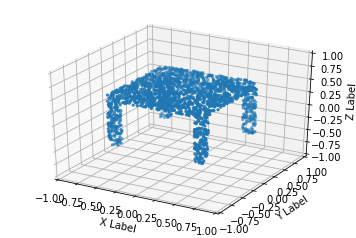

The displayed point cloud data is table


In [3]:
# plot point cloud 
def plot_ply(file):
    fig = plt.figure()
    ax = fig.add_subplot(111,projection='3d')
    ax.set_ylim(-1,1)
    ax.set_xlim(-1,1)
    ax.set_zlim(-1,1)
    x=file[:,0]
    y=file[:,1]
    z=file[:,2]
    ax.scatter(x, y, z, marker='.', zdir='z')
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    plt.show()
    
# Randomly select one point cloud data (0 - 3991) and illustrate
data_idx = 0
plot_ply(train_points_r[data_idx])
print("The displayed point cloud data is", modelnet10_categories[train_labels_r[data_idx][0]])

## Exercise 2: Point cloud classification using MVCNN

- Reference: H. Su, S. Maji, E. Kalogerakis, E. Learned-Miller, "Multi-view Convolutional Neural Networks for 3D Shape Recognition," IEEE Inter. Conf. on Computer Vision (ICCV), Santiago, Chile, Dec. 2015, pp. 945-953, http://vis-www.cs.umass.edu/mvcnn/

In [4]:
# Define MVCNN model
NUM_DIM = 32
def rotate(pc, deg):
    R = np.array([(1,0,0),
        (0,np.cos(deg),np.sin(deg)),
        (0,-np.sin(deg),np.cos(deg))])   
    pc[:] = pc[:] - [0.5,0.5,0.5]
    pc =  np.dot(pc, R) 
    pc[:] = pc[:] + [0.5,0.5,0.5]
    np.clip(pc,0,1)
    return pc
        
def pointcloud2volume(pc, num_of_angles,angle_idx, dim=NUM_DIM):
    vol = np.zeros((dim, dim, dim))
    angle = (360 / num_of_angles) * angle_idx *  math.pi / 180
    #angle = angle * angle_idx * math.pi / 180
    pcc = np.copy(pc)
    pcc = rotate(pcc, angle)
    pcc[:] *= (dim-1)
    pcc = pcc.astype(int)
    pcc = np.clip(pcc,0,dim=1)
    vol[pcc[:,0], pcc[:,1], pcc[:,2]] = 1.0
    return vol

#point cloud to volume
def pointcloud2volumeAngled(pc, num_of_angles,angle_idx, dim=NUM_DIM):
    vol = np.zeros((dim, dim, dim))
    angle = (360 / num_of_angles) * (np.pi / 180) * angle_idx   
    pcc = np.copy(pc)
    pcc = rotate(pcc, angle)
    pcc[:] = pcc[:]*(dim-1)
    pcc = pcc.astype(int)
    pcc = np.clip(pcc,0,dim-1)
    vol[pcc[:,0], pcc[:,1], pcc[:,2]] = 1.0
    return vol

#volume to depthmap
def vol2depthmap(v, bg_val=40.):
    k=v.argmax(2)
    for x in range(NUM_DIM):
            for y in range(NUM_DIM):
                if (k[x,y] == 0):
                    k[x,y] = bg_val
             
    return k

#plotting depth map
def plot_depth_map(img, num_rot):
    volmap = []
    depthmap = []
    angled_vector= []
    for i in range(num_rot):
        volmap = pointcloud2volumeAngled(img, num_rot, i)
        depthmap = vol2depthmap(volmap)
        angled_vector.append(depthmap)
    plt.imshow(np.vstack(angled_vector), cmap='jet')
    plt.colorbar()
    plt.show()

#creates the Vectored dataset with every angle for each image

def CreateAngledDataset(samples, num_of_angles):
    datalength = len(samples)    
    MVDS = np.zeros((datalength, num_of_angles, NUM_DIM, NUM_DIM)) #multiview Dataset
    SMVDS = np.zeros((num_of_angles, NUM_DIM, NUM_DIM))  #single multiview Dataset
    for i in range (datalength):
        for angle in range(num_of_angles):
            pic = pointcloud2volumeAngled(samples[i], num_of_angles, angle)
            picdepth = vol2depthmap(pic)
            SMVDS[angle] = picdepth
        MVDS[i] = SMVDS
    return MVDS

class SplitLayer(Layer):
    """
    Layer expects a tensor (multi-dimensonal array) of shape (samples, views, ...)
    and returns a list of #views elements, each of shape (samples, ...)
    """
    
    def __init__(self, num_splits, **kwargs):
        self.num_splits = num_splits
        super(SplitLayer, self).__init__(**kwargs)
    
    def call(self, x):
        return [x[:, i] for i in range(self.num_splits)]

    def compute_output_shape(self, input_shape):
        return [(input_shape[0],) + input_shape[2:]]*self.num_splits
    
    
def make_cnn():    
    num_channels = 32
    cnn = Sequential()
    cnn.add(Conv2D(num_channels, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 1)))
    cnn.add(MaxPooling2D(pool_size=(2, 2)))
    cnn.add(Conv2D(num_channels*2, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D(pool_size=(2, 2)))
    cnn.add(Dropout(0.25))
    cnn.add(Flatten())
    cnn.add(Dense(128, activation='relu'))

    return cnn


In [6]:
# Define the MVCNN approach
num_of_angles = 10
batch_size = 128
num_classes = 10
input = Input((num_of_angles, 32, 32, 1))
views = SplitLayer(num_of_angles)(input)
proc_views = []
cnn = make_cnn() # create the model
for v in views:
    proc_views.append(cnn(v))

single_vector = keras.layers.merge.Maximum()(proc_views)
x = Dense(128)(single_vector)
x = Dense(num_classes, activation='softmax')(x)
model_mvcnn = Model(input, x)
model_mvcnn.summary()

#Data assignment
samplesDataTrain = CreateAngledDataset(train_points_r, num_of_angles)
samplesDataTest = CreateAngledDataset(test_points_r, num_of_angles)
print("Original data: %s, labels: %s, created: %s" % (train_points_r.shape, train_labels_r.shape, samplesDataTrain.shape))

(x_train, y_train) = (samplesDataTrain, train_labels_r)
(x_test, y_test) = (samplesDataTest, test_labels_r)

# input image dimensions
img_rows, img_cols = 32, 32

x_train = x_train.reshape(x_train.shape[0], num_of_angles, img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], num_of_angles, img_rows, img_cols, 1)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 10, 32, 32, 1 0                                            
__________________________________________________________________________________________________
split_layer_1 (SplitLayer)      [(None, 32, 32, 1),  0           input_1[0][0]                    
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 128)          313856      split_layer_1[0][0]              
                                                                 split_layer_1[0][1]              
                                                                 split_layer_1[0][2]              
                                                                 split_layer_1[0][3]              
          

In [7]:
# Train a MVCNN model
model_mvcnn.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
model_mvcnn.fit(x_train, y_train,batch_size=batch_size, epochs=20, verbose=2)

# # Save trained models into harddisk
# model_mvcnn.save_weights("data/model_mvcnn_v0805.h5")
# print("Saved model to disk")


Epoch 1/20
 - 4s - loss: 2.1329 - acc: 0.2255
Epoch 2/20
 - 1s - loss: 1.6973 - acc: 0.4465
Epoch 3/20
 - 1s - loss: 1.3494 - acc: 0.5630
Epoch 4/20
 - 1s - loss: 1.1552 - acc: 0.6387
Epoch 5/20
 - 1s - loss: 1.0292 - acc: 0.6733
Epoch 6/20
 - 1s - loss: 0.9596 - acc: 0.6903
Epoch 7/20
 - 1s - loss: 0.8730 - acc: 0.7106
Epoch 8/20
 - 1s - loss: 0.8035 - acc: 0.7334
Epoch 9/20
 - 1s - loss: 0.7653 - acc: 0.7482
Epoch 10/20
 - 1s - loss: 0.7208 - acc: 0.7632
Epoch 11/20
 - 1s - loss: 0.7095 - acc: 0.7657
Epoch 12/20
 - 1s - loss: 0.6652 - acc: 0.7752
Epoch 13/20
 - 1s - loss: 0.6524 - acc: 0.7800
Epoch 14/20
 - 1s - loss: 0.6242 - acc: 0.7935
Epoch 15/20
 - 1s - loss: 0.5873 - acc: 0.8038
Epoch 16/20
 - 1s - loss: 0.5771 - acc: 0.8056
Epoch 17/20
 - 1s - loss: 0.5419 - acc: 0.8196
Epoch 18/20
 - 1s - loss: 0.5473 - acc: 0.8254
Epoch 19/20
 - 1s - loss: 0.5049 - acc: 0.8319
Epoch 20/20
 - 1s - loss: 0.5136 - acc: 0.8249


In [7]:

# load pre-trained json and create model
#json_file = open('data/model_mvcnn_v0805.json', 'r')
#loaded_model_json = json_file.read()
#json_file.close()
#model_mvcnn = model_from_json(loaded_model_json)
# load weights into new model
model_mvcnn.load_weights("data/model_mvcnn_v0805.h5")
print("Loaded model from disk")


Loaded model from disk


In [8]:
# model evaluation

y_test_predict = model_mvcnn.predict(x_test)
print(confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_test_predict, axis=1)))


[[24 14  2  0  0  0  0  8  1  1]
 [ 1 89  2  0  0  0  0  2  1  5]
 [ 0  4 90  0  0  2  0  0  2  2]
 [ 0 21  2 22  1  3  2 10 14 11]
 [ 0  3  0  0 55  1 14  0  2 11]
 [ 0  1  0  0  1 91  0  1  1  5]
 [ 0 10  1  1 11  0 52  1  1  9]
 [ 0  8  1  1  2  1  1 83  1  2]
 [ 0 17 16 12  0  0  0  0 53  2]
 [ 1  2  9  2  0  0  1  0  2 83]]


$\color{red}{\text{Question 1. Complete the code to perform point cloud data classification.}}$

Tasks

- Select one test point cloud data from `x_test`
- visualize your selected data using the function `plot_ply`
- Perform classification on your selected data using the trained `model_mvcnn`
- Display the true label and predicted label for your selected data using `modelnet10_categories`

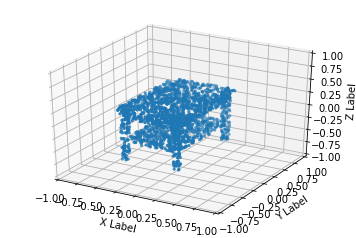

The displayed point cloud data is toilet


In [18]:
# Provide you code here
# Step 1, select the test data from x_test
test_case_index = np.random.randint(0, x_test.shape[0])
test_case = x_test[test_case_index]
#
# Step 2, plot the selected data using the function `plot_ply()`
plot_ply(test_points_r[test_case_index])
#
# Step 3, predict the class using the trained model
# Note: you need to extend the data in the first dimension, say, (1, 10, 32, 32, 1)
test_data = test_case.reshape((1,) + test_case.shape)
#
# Step 4, Display the true label and predicted label
# note: you need to apply np.argmax() to decode the one-hot coding of the categories
#
y_test_predict = model_mvcnn.predict(test_data)
print("The displayed point cloud data is", modelnet10_categories[np.argmax(y_test_predict)])